# Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import random 
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
import operator

import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing import sequence
import keras.backend as K

import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# Function for cleaning data

In [3]:
def clean_df(df):
    
    """
    
    Aim: Clean a dataframe by dropping Nan values and duplicate values
    
    Parameters
    ----------
    df (dataframe): dataframe to clean
    
    Returns:
    ----------
    df_cleaned (dataframe): dataframe with no Nan values and no duplicate values
    
    """
    
    df_no_null = df.dropna()
    df_no_null = df_no_null.reset_index(drop = True)

    df_cleaned = df_no_null.drop_duplicates()
    df_cleaned = df_cleaned.reset_index(drop = True)
    
    return df_cleaned

# Functions for text pre-processing and visualisation

In [4]:
def lemmatize_text(text):
    
    """
    
    Aim: Perform lemmatization on a given string of text
    
    Parameters
    ----------
    text (str): string to lemmatize
    
    Returns:
    ----------
    lemmatized_words (list): list containing words from the lemmatized text
    
    """
    
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    lemmatized_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    
    return lemmatized_words


def join_words(list_of_words):
    
    """
    
    Aim: Combine a given list of words into a sentence
    
    Parameters
    ----------
    list_of_words (list): a list of words
    
    Returns:
    ----------
    sentence (str): a string that is formed by combining all the words together with a space in between
    
    """
    
    sentence = list_of_words[0]
    
    for word in list_of_words[1:]:
        sentence = sentence + " " + word
        
    return sentence


def text_preprocessing(df, text_col_name, remove_stop_words):
    
    """
    
    Aim: Convert text to lower cases and keep only alphabetical characters while also providing option to remove stop words
    
    Parameters
    ----------
    df (dataframe): dataframe to do text preprocessing
    text_col_name (str): column of dataframe to perform text preprocessing
    remove_stop_words (bool): whether to remove stop words or not
    
    Returns:
    ----------
    df_processed (dataframe): dataframe after doing text preprocessing
    
    """
    
    df_processed = df.copy()
    
    df_processed["cleaned_text"] = df_processed[text_col_name].str.lower() #convert all cases to lower case
    df_processed["cleaned_text"] = df_processed["cleaned_text"].str.replace(r'<[^<>]*>', '', regex = True) #remove html tags
    df_processed["cleaned_text"] = df_processed["cleaned_text"].str.replace("[^a-zA-Z]", " ") #keep only letters in the text
    df_processed["cleaned_text"] = df_processed["cleaned_text"].apply(lemmatize_text) #lemmatize text
    df_processed["cleaned_text"] = df_processed["cleaned_text"].apply(join_words)
    
    if remove_stop_words == True:
        stop = stopwords.words('english') #stop words
        df_processed["cleaned_text"] = df_processed["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return df_processed


def generate_word_cloud(word_frequencies_dict):

    """
    
    Aim: Generate word cloud based on a dictionary containing vocab and their frequencies
    
    Parameters
    ----------
    word_frequencies_dict (dict): dictionary containing vocab and their frequencies
    
    Returns:
    ----------
    None
    
    """      

    wordcloud = WordCloud(background_color="white", width = 800, height = 400)
    wordcloud.generate_from_frequencies(frequencies = word_frequencies_dict)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();
    

def generate_bar_chart(word_frequencies_dict, number_of_words_to_show, type_of_review):
    
    
    """
    
    Aim: Generate bar chart based on a dictionary containing vocab and their frequencies
    
    Parameters
    ----------
    word_frequencies_dict (dict): dictionary containing vocab and their frequencies
    number_of_words_to_show (int): number of top occuring words to be shown in bar chart
    
    Returns:
    ----------
    None
    
    """  
    
    sorted_word_occurences = sorted(word_frequencies_dict.items(), key = operator.itemgetter(1))
    sorted_word_occurences.reverse()
    
    common_words = []
    times_occured = []
    for sorted_item in sorted_word_occurences[:number_of_words_to_show]:
        common_words.append(sorted_item[0])
        times_occured.append(sorted_item[1])
        
    occurences_df = pd.DataFrame()
    occurences_df["Words"] = common_words
    occurences_df["Occurences"] = times_occured
    
    occurences_df.plot.bar(x = "Words", y = "Occurences", color = "orange", figsize=(14, 7))
    plt.title("Occurences of top " + str(number_of_words_to_show) + " most common words (" + type_of_review + ")", fontsize = 16, y = 1.03)
    plt.xlabel("Words", fontsize = 16)
    plt.ylabel("Occurences", fontsize = 16)
    plt.xticks(fontsize = 10, rotation = 0)
    plt.yticks(fontsize = 14)
    plt.show();

# Function to check data distribution

In [5]:
def distribution_of_data(df, label_col_name, class_0_name, class_1_name):
    
    """
    
    Aim: Print distribution of data
    
    Parameters
    ----------
    df (dataframe): dataframe containing data
    label_col_name (str): column of dataframe to see distribution of data
    class_0_name (str): name of class 0 of data
    class_1_name (str): name of class 1 of data
    
    Returns:
    ----------
    df_cleaned (dataframe): dataframe with no Nan values and no duplicate values
    
    """
    
    print(class_0_name + ":", df[label_col_name].isin([0]).sum()) 
    print(class_1_name + ":", df[label_col_name].sum())
    print("Total data:", len(df))

# Functions to help with classification

In [6]:
def summary_of_data(y_train, y_test):
    
    """
    
    Aim: Print summary of training data for each fold
    
    Parameters
    ----------
    y_train (array of int64): array of y_train values
    y_test (array of int64): array of y_test values
    
    Returns:
    ----------
    None
    
    """  
    
    print("\nTraining data summary:")
    print("Normal data:", len(y_train) - sum(y_train)) #0 is normal
    print("Sql injection data:", sum(y_train)) #1 is sql injected data
    print("Total data:", len(y_train))

    print("\nTesting data summary:")
    print("Normal data:", len(y_test) - sum(y_test)) #0 is normal
    print("Sql injection data:", sum(y_test)) #1 is sql injected data
    print("Total data:", len(y_test))
    print("")
    
    
def graphs_for_k_fold(number_of_splits, accuracy_list, f1_score_list):
    
    """
    
    Aim: Plot the graph after k-folds for comparing the accuracy and F1 score for each fold
    
    Parameters
    ----------
    number_of_splits (int): value of k in k_fold
    accuracy_list (list): list of accuracy values for each fold
    f1_score_list (list): list of F1 score values for each fold
    
    Returns:
    ----------
    None
    
    """ 
    
    plt.figure()
    plt.plot(range(1, number_of_splits + 1), accuracy_list);
    plt.title("Accuracy across " + str(number_of_splits) + " folds")
    plt.xlabel("Fold Number")
    plt.ylabel("Accuracy")
    plt.show();
    
    plt.figure()
    plt.plot(range(1, number_of_splits + 1), f1_score_list)
    plt.title("F1 score across " + str(number_of_splits) + " folds")
    plt.xlabel("Fold Number")
    plt.ylabel("F1 score")
    plt.show();


def extract_sentences_with_matched_index(list_of_sentences, index_list):
    
    """
    
    Aim: Get a list of sentences whose index match the required indexes in index_list
    
    Parameters
    ----------
    list_of_sentences (list): list of all sentences
    index_list (array of int32): array of required indexes
        
    Returns:
    ----------
    list_of_chosen_sentences (list): list of sentences whose index matched the required indexes in index_list
    
    """
    
    list_of_chosen_sentences = []
    for index in index_list:
        list_of_chosen_sentences.append(list_of_sentences[index])
    return list_of_chosen_sentences


def model_performance(accuracy_list, f1_score_list, word_embeddings_used, model_name):
    
    """
    
    Aim: Print average accuracy and F1 score for the model combinations for each fold
    
    Parameters
    ----------
    accuracy_list (list): list of accuracy values for each fold
    f1_score_list (list): list of F1 score values for each fold
    word_embeddings_used (str): name of text embedding technique used
    model_name (str): name of classification model used
    
    Returns:
    ----------
    None
    
    """  
    
    print("Average accuracy of " + model_name + " Model using " + word_embeddings_used + ": " + str(np.mean(accuracy_list)))
    print("Average F1-score of " + model_name + " Model (class 1 as positive) using " + word_embeddings_used + ": " + str(np.mean(f1_score_list)))
    print("")   
    
    
def label_to_class(label, class_0_name, class_1_name):
    
    """
    
    Aim: Convert the label to the class name
    
    Parameters
    ----------
    label (Array of int32): label given
    class_0_name (str): name of class 0 of data
    class_1_name (str): name of class 1 of data
    
    Returns:
    ----------
    str_to_return (str): name of class that matches the label
    
    """
    
    if label == 0:    
        str_to_return = class_0_name
    else:
        str_to_return = class_1_name
        
    return str_to_return

# Evaluating Model Peformance using Cross-Validation (One-Hot Encoding)

In [7]:
def one_hot_encoding_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab):
    
    """
    
    Aim: Get the One-Hot Encoded matrix of training and testing sentences and the One-Hot Encoding vectorizer
    
    Parameters
    ----------
    list_of_training_sentences (list): list of training sentences split by K-Fold
    list_of_testing sentences (list): list of testing sentences split by K-Fold
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    
    Returns:
    ----------
    train_data (sparse.csr.csr_matrix): compressed sparse row matrix from One-Hot Encoding
    test_data (sparse.csr.csr_matrix): compressed sparse row matrix from One-Hot Encoding
    vectorizer (CountVectorizer object): One-Hot Encoding vectorizer fitted with training data
    
    """    
    
    vectorizer = CountVectorizer(lowercase = False, token_pattern= "\S+", vocabulary = unique_vocab, binary = True)
    train_data = vectorizer.fit_transform(list_of_training_sentences)
    test_data = vectorizer.transform(list_of_testing_sentences)

    print("One-Hot Encoding completed")
        
    return train_data, test_data, vectorizer


def stratified_k_fold_cross_validation_one_hot(clf, list_of_sentences, labels, unique_vocab, number_of_splits, show_data_summary, show_graphs):
    
    """
    
    Aim: Perform stratified K-fold cross validation on the dataset while measuring Accuracy and F1 score at each fold
    
    Parameters
    ----------
    clf: Base classification model
    list_of_sentences (list): list of all sentences
    labels (array of int64): list of labels for the corresponding sentences
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    number_of_splits (int): value of k in k_fold
    show_data_summary (bool): whether to print summary of data or not
    show_graphs (bool): whether to show accuracy and f1 score graphs at each fold or not
    
    Returns: vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list
    ----------
    vectorizer_list (list): list of fitted One-Hot Encoding vectorizer for each fold
    accuracy_list (list): list of accuracy values for each fold
    f1_score_list (list): list of F1 score values for each fold
    clf_fitted_list (list): list of fitted classification model for each fold
    time_taken_list (list): list of time taken (in seconds) for each fold
    
    """  
    
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 0)
    
    fold_value = 1
    vectorizer_list = []
    accuracy_list = []
    f1_score_list = []
    clf_fitted_list = []
    time_taken_list = []
    
    for train_index, test_index in skf.split(list_of_sentences, labels):
    
        clf_fitted = clone(clf) #clone base model so model that is used for fit will reset at every fold    
    
        start = time.time()
        
        list_of_training_sentences = extract_sentences_with_matched_index(list_of_sentences, train_index)
        list_of_testing_sentences = extract_sentences_with_matched_index(list_of_sentences, test_index)
        X_train, X_test, vectorizer = one_hot_encoding_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab)
        vectorizer_list.append(vectorizer)
        
        y_train, y_test = labels[train_index], labels[test_index]
        
        if show_data_summary:
            
            print("Fold", fold_value, "summary:")
            summary_of_data(y_train, y_test)
        
        clf_fitted.fit(X_train, y_train)
        accuracy_list.append(accuracy_score(clf_fitted.predict(X_test), y_test))
        f1_score_list.append(f1_score(clf_fitted.predict(X_test), y_test, pos_label = 1)) #positive label is set to 1 as 1 is for positive reviews
        clf_fitted_list.append(clf_fitted)

        end = time.time()
        time_taken = end - start
        time_taken_list.append(time_taken)
        print("Fold", fold_value, "/", number_of_splits, "completed")
        print("Time elapsed for training of current fold:", time_taken, "seconds\n")
        fold_value = fold_value + 1
      
    if show_graphs:
        graphs_for_k_fold(number_of_splits, accuracy_list, f1_score_list)
    
    return vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list

# Evaluating Model Peformance using Cross-Validation (Bag-of-Words)

In [8]:
def BoW_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab):
        
    """
    
    Aim: Get the BoW vectorized matrix of training and testing sentences and the BoW vectorizer
    
    Parameters
    ----------
    list_of_training_sentences (list): list of training sentences split by K-Fold
    list_of_testing sentences (list): list of testing sentences split by K-Fold
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    
    Returns:
    ----------
    train_data (sparse.csr.csr_matrix): compressed sparse row matrix from BoW
    test_data (sparse.csr.csr_matrix): compressed sparse row matrix from BoW
    vectorizer (CountVectorizer object): BoW vectorizer fitted with training data
    
    """
    
    vectorizer = CountVectorizer(lowercase = False, token_pattern= "\S+", vocabulary = unique_vocab, binary = False)
    train_data = vectorizer.fit_transform(list_of_training_sentences)
    test_data = vectorizer.transform(list_of_testing_sentences)

    print("Bag-of-Words completed")
        
    return train_data, test_data, vectorizer


def stratified_k_fold_cross_validation_BoW(clf, list_of_sentences, labels, unique_vocab, number_of_splits, show_data_summary, show_graphs):
    
    """
    
    Aim: Perform stratified K-fold cross validation on the dataset while measuring Accuracy and F1 score at each fold
    
    Parameters
    ----------
    clf: Base classification model
    list_of_sentences (list): list of all sentences
    labels (array of int64): list of labels for the corresponding sentences
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    number_of_splits (int): value of k in k_fold
    show_data_summary (bool): whether to print summary of data or not
    show_graphs (bool): whether to show accuracy and f1 score graphs at each fold or not
    
    Returns: vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list
    ----------
    vectorizer_list (list): list of fitted BoW vectorizer for each fold
    accuracy_list (list): list of accuracy values for each fold
    f1_score_list (list): list of F1 score values for each fold
    clf_fitted_list (list): list of fitted classification model for each fold
    time_taken_list (list): list of time taken (in seconds) for each fold
    
    """ 
    
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 0)
    
    fold_value = 1
    vectorizer_list = []
    accuracy_list = []
    f1_score_list = []
    clf_fitted_list = []
    time_taken_list = []
    
    for train_index, test_index in skf.split(list_of_sentences, labels):
    
        clf_fitted = clone(clf) #clone base model so model that is used for fit will reset at every fold    
    
        start = time.time()
        
        list_of_training_sentences = extract_sentences_with_matched_index(list_of_sentences, train_index)
        list_of_testing_sentences = extract_sentences_with_matched_index(list_of_sentences, test_index)
        X_train, X_test, vectorizer = BoW_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab)
        vectorizer_list.append(vectorizer)
        
        y_train, y_test = labels[train_index], labels[test_index]
        
        if show_data_summary:
            
            print("Fold", fold_value, "summary:")
            summary_of_data(y_train, y_test)
        
        clf_fitted.fit(X_train, y_train)
        accuracy_list.append(accuracy_score(clf_fitted.predict(X_test), y_test))
        f1_score_list.append(f1_score(clf_fitted.predict(X_test), y_test, pos_label = 1)) #positive label is set to 1 as 1 is for positive reviews
        clf_fitted_list.append(clf_fitted)

        end = time.time()
        time_taken = end - start
        time_taken_list.append(time_taken)
        print("Fold", fold_value, "/", number_of_splits, "completed")
        print("Time elapsed for training of current fold:", time_taken, "seconds\n")
        fold_value = fold_value + 1
      
    if show_graphs:
        graphs_for_k_fold(number_of_splits, accuracy_list, f1_score_list)
    
    return vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list

# Evaluating Model Peformance using Cross-Validation (Term Frequency-Inverse Document Frequency)

In [10]:
def TF_IDF_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab):
    
    """
    
    Aim: Get the TF-IDF vectorized matrix of training and testing sentences and the TF-IDF vectorizer
    
    Parameters
    ----------
    list_of_training_sentences (list): list of training sentences split by K-Fold
    list_of_testing sentences (list): list of testing sentences split by K-Fold
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    
    Returns:
    ----------
    train_data (sparse.csr.csr_matrix): compressed sparse row matrix from TF-IDF
    test_data (sparse.csr.csr_matrix): compressed sparse row matrix from TF-IDF
    vectorizer (TfidfVectorizer object): TF-IDF vectorizer fitted with training data
    
    """
    
    vectorizer = TfidfVectorizer(lowercase = False, token_pattern= "\S+", vocabulary = unique_vocab, binary = False)
    train_data = vectorizer.fit_transform(list_of_training_sentences)
    test_data = vectorizer.transform(list_of_testing_sentences)

    print("TF-IDF completed")
        
    return train_data, test_data, vectorizer


def stratified_k_fold_cross_validation_TF_IDF(clf, list_of_sentences, labels, unique_vocab, number_of_splits, show_data_summary, show_graphs):
    
    """
    
    Aim: Perform stratified K-fold cross validation on the dataset while measuring Accuracy and F1 score at each fold
    
    Parameters
    ----------
    clf: Base classification model
    list_of_sentences (list): list of all sentences
    labels (array of int64): list of labels for the corresponding sentences
    unique_vocab (list): list of all the unique vocab in all the sentences from the training dataframe
    number_of_splits (int): value of k in k_fold
    show_data_summary (bool): whether to print summary of data or not
    show_graphs (bool): whether to show accuracy and f1 score graphs at each fold or not
    
    Returns: vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list
    ----------
    vectorizer_list (list): list of fitted TF-IDF vectorizer for each fold
    accuracy_list (list): list of accuracy values for each fold
    f1_score_list (list): list of F1 score values for each fold
    clf_fitted_list (list): list of fitted classification model for each fold
    time_taken_list (list): list of time taken (in seconds) for each fold
    
    """ 
    
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 0)
    
    fold_value = 1
    vectorizer_list = []
    accuracy_list = []
    f1_score_list = []
    clf_fitted_list = []
    time_taken_list = []
    
    for train_index, test_index in skf.split(list_of_sentences, labels):
    
        clf_fitted = clone(clf) #clone base model so model that is used for fit will reset at every fold    
    
        start = time.time()
        
        list_of_training_sentences = extract_sentences_with_matched_index(list_of_sentences, train_index)
        list_of_testing_sentences = extract_sentences_with_matched_index(list_of_sentences, test_index)
        X_train, X_test, vectorizer = TF_IDF_vectorization(list_of_training_sentences, list_of_testing_sentences, unique_vocab)
        vectorizer_list.append(vectorizer)
        
        y_train, y_test = labels[train_index], labels[test_index]
        
        if show_data_summary:
            
            print("Fold", fold_value, "summary:")
            summary_of_data(y_train, y_test)
        
        clf_fitted.fit(X_train, y_train)
        accuracy_list.append(accuracy_score(clf_fitted.predict(X_test), y_test))
        f1_score_list.append(f1_score(clf_fitted.predict(X_test), y_test, pos_label = 1)) #positive label is set to 1 as 1 is for positive reviews
        clf_fitted_list.append(clf_fitted)

        end = time.time()
        time_taken = end - start
        time_taken_list.append(time_taken)
        print("Fold", fold_value, "/", number_of_splits, "completed")
        print("Time elapsed for training of current fold:", time_taken, "seconds\n")
        fold_value = fold_value + 1
      
    if show_graphs:
        graphs_for_k_fold(number_of_splits, accuracy_list, f1_score_list)
    
    return vectorizer_list, accuracy_list, f1_score_list, clf_fitted_list, time_taken_list

# Function for Convolutional Neural Network (CNN)

In [23]:
def get_f1(y_true, y_pred): 
    """
    
    Aim: Get F1 Score of each epoch of CNN
    
    Parameters
    ----------
    y_true (array of int64): array of y_true values
    y_pred (array of int64): array of y_pred values
    
    Returns: f1_val
    ----------
    f1_val (float): F1_value of the CNN model
    
    """ 

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def CNN(X_train, y_train, X_test, y_test):
    """
    
    Aim: Perform CNN on the given train and test set while measuring Accuracy and F1 Value of each epoch
    
    Parameters
    ----------
    X_train (array of int64): array of X_train values
    y_train (array of int64): array of y_train values
    X_test (array of int64): array of X_test values    
    y_test (array of int64): array of y_test values
    
    Returns: None
    ----------
    
    """ 
    max_words = 1000

    one_hot_X_train = [one_hot(s, max_words) for s in X_train]
    X_train = pad_sequences(one_hot_X_train, maxlen=max_words, padding='post')

    one_hot_X_test = [one_hot(s, max_words) for s in X_test]
    X_test = pad_sequences(one_hot_X_test, maxlen=max_words, padding='post')

    model = Sequential()
    model.add(Embedding(1000, 32, input_length=max_words)) 
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])
    model.summary()
 

    model.fit(X_train, y_train, epochs = 10, verbose=2) # 10 passes thorugh training data
    loss, acc, f1 = model.evaluate(X_test, y_test, verbose=0)


    print('Test Accuracy: %f' % (acc))
    print('F1-Score: ' + str(f1))



# Training the Text Embedding Model with full train dataset (Term Frequency-Inverse Document Frequency)

In [11]:
def TF_IDF_vectorization_full(list_of_training_sentences, unique_vocab):
    
    """
    
    Aim: Get the TF-IDF vectorized matrix of training sentences and the TF-IDF vectorizer
    
    Parameters
    ----------
    list_of_training_sentences (list): list of sentences from the training dataframe
    unique_vocab (list): list of all the unique vocab in the training sentences
    
    Returns:
    ----------
    train_data (sparse.csr.csr_matrix): compressed sparse row matrix from TF-IDF vectorization
    TF_IDF_vectorizer (TfidfVectorizer object): TF-IDF vectorizer fitted with training data
    
    """     
    
    TF_IDF_vectorizer = TfidfVectorizer(lowercase = False, token_pattern= "\S+", vocabulary = unique_vocab, binary = False)
    print("TF-IDF vectorization completed")
    
    train_data = TF_IDF_vectorizer.fit_transform(list_of_training_sentences)    
        
    return train_data, TF_IDF_vectorizer

# Function for predicting new statements

In [12]:
def predict_statement(text_embedding_model, classification_model, sentence_to_classify):
    
    """
    
    Aim: Predict the class of statement given the text embedding model and classification model
    
    Parameters
    ----------
    text_embedding_model (TfidfVectorizer object): TF_IDF vectorizer
    classification_model (LogisticRegression object): Logistic Regression Model
    list_of_sentences_to_classify (list): sentence to perform classification on
    show_logs (bool): whether to print logs when doing prediction
        
    Returns:
    ----------
    predicted_label (list): list of predicted label for the corresponding sentence to classify
    
    Note: [1] if Positive Review, [0] if Negative Review, [-1] if there are errors in classification
    
    """         
        
    # start = time.time()
    vector = text_embedding_model.transform([sentence_to_classify])
    embeddings_for_statement_in_list = (vector.todense()).tolist()
    unique_values = set(embeddings_for_statement_in_list[0])
    if((len(unique_values) == 1) and (0 in unique_values)):
        predicted_label = [-1]
    else:
        predicted_label = classification_model.predict(vector)
            
    # end = time.time()
    
    # print("Time elapsed for Logistic Regression Model classification (TF-IDF vectorization):", (end - start), "seconds")
    
    return predicted_label

# Function for interpretability of model and how it predicts (only works for TF-IDF)

In [13]:
def explain_with_lime(text_embedding_model, classification_model, sentence_to_classify):
    
    """
    
    Aim: Interpretation and visualisations of how the classifier predict the sentence using Lime
    
    Parameters
    ----------
    text_embedding_model (TfidfVectorizer object): TF_IDF vectorizer
    classification_model (LogisticRegression object): Logistic Regression Model
    sentence_to_classify (str): sentence to perform classification and check interpretation on
        
    Returns:
    ----------
    None    
    
    """ 
    
    print("Explaination using LIME:")
    
    pipe_line = make_pipeline(text_embedding_model, classification_model)

    class_names = ["0 (Negative Review)", "1 (Positive Review)"]
    lime_explainer = LimeTextExplainer(class_names = class_names, split_expression = " ",  random_state = 0)

    lime_exp = lime_explainer.explain_instance(sentence_to_classify, pipe_line.predict_proba, num_features = 6) #print top 6 features
    print("Probability of review being classified as 1 (Positive Review):", round(pipe_line.predict_proba([sentence_to_classify])[0,1], 4))
    print("Review given:", sentence_to_classify)
    
    lime_exp.as_pyplot_figure()
    plt.show();

# Function for Cosine Similarity

In [14]:
def get_counts(text):
    
    """
    
    Aim: Convert text to list of (index of word, count of word) to speed up calculation for Cosine Similarity
    
    Parameters
    ----------
    text (str): text to obtain to list of count of words
        
    Returns:
    ----------
    counts (list): list of (index of word, count of word)
    
    """
    
    vector = TF_IDF_vectorizer.transform([text])
    non_zero_indexes = (vector.nonzero())[1]
    embeddings_for_statement_in_list = (vector.todense()).tolist()
    
    counts = []
    for index in non_zero_indexes:
        counts.append((index, (embeddings_for_statement_in_list[0])[index]))
    return(counts)

def cosinesim(text1, text2):
    
    """
    
    Aim: Find the Cosine Similarity between 2 text
    
    Parameters
    ----------
    text1 (str): text1 to be compared
    text2 (str): text2 to be compared
        
    Returns:
    ----------
    result (float): value of Cosine Similarity
    
    """
    
    count1 = get_counts(text1)
    count2 = get_counts(text2)
    
    den1 = 0
    den2 = 0
    for i in count1:
        den1+=i[1]**2
    for j in count2:
        den2+=j[1]**2
    
    num = 0
    a = 0
    b = 0
    while True:
        if a == len(count1) or b == len(count2):
            break
        if count1[a][0] == count2[b][0]:
            num += count1[a][1]*count2[b][1]
            a +=1
            b +=1
        elif count1[a][0] > count2[b][0]:
            a += 1
        else:
            b += 1
    result = num/((den1**0.5)*(den2**0.5))
    return result

def find_top_5(textlst, index):
    
    """
    
    Aim: Find the top 5 highest Cosine Similarity compared to a chosen text
    
    Parameters
    ----------
    textlst (list): list of text where top 5 Cosine Similarity should be found
    index (int): index of text in textlst to compare the highest Cosine Similarity with
        
    Returns:
    ----------
    top5 (list): list of top 5 Cosine Similarity in format (value of Cosine Similarity, index of text in list)
    
    """
    
    top5 = []
    textlst = textlst.copy()
    compare = textlst[index]
    
    for i in range(len(textlst)):
        if i == index:
            continue
        if len(top5) < 5:
            top5.append([cosinesim(textlst[i],compare),i])
        else:
            if i % 1000 == 0:
                print("Ran first",i,"indexes")
            cossim = cosinesim(textlst[i],compare)
            if cossim > top5[0][0]:
                top5[0] = [cossim,i]
        top5.sort()
    return(top5)

# Main

In [15]:
#Read data

reviews_df = pd.read_csv("IMDB_Dataset.csv", header = 0)

In [16]:
reviews_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [17]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [18]:
#Change positive review to class 1, negative review to class 0

reviews_df["is_positive"] = (reviews_df["sentiment"] == "positive") * 1

In [19]:
reviews_df

,review,sentiment,is_positive
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [20]:
#Drop null values and duplicates

reviews_df_cleaned = clean_df(reviews_df)
print(reviews_df_cleaned["is_positive"].value_counts())
print("")
distribution_of_data(reviews_df_cleaned, "is_positive", "Negative Reviews", "Positive Reviews")

1    24884
0    24698
Name: is_positive, dtype: int64

Negative Reviews: 24698
Positive Reviews: 24884
Total data: 49582


# Text pre-processing and visualisation (With stop words)

In [26]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dengc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [28]:
remove_stop_words = False
df_processed = text_preprocessing(reviews_df_cleaned, "review", remove_stop_words)

number_of_words_to_show = 15

C:\Users\dengc\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: The default value of regex will change from True to False in a future version.


In [29]:
df_processed

,review,sentiment,is_positive,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewer ha mentioned that af...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this wa a wonderful way to spend tim...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...
...,...,...,...,...
49577,I thought this movie did a down right good job...,positive,1,i thought this movie did a down right good job...
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,bad plot bad dialogue bad acting idiotic direc...
49579,I am a Catholic taught in parochial elementary...,negative,0,i am a catholic taught in parochial elementary...
49580,I'm going to have to disagree with the previou...,negative,0,i m going to have to disagree with the previou...



Word cloud and bar chart of positive reviews (with stop words):


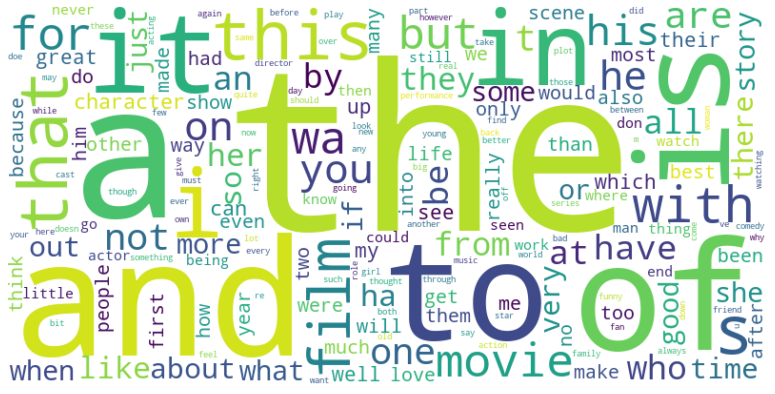

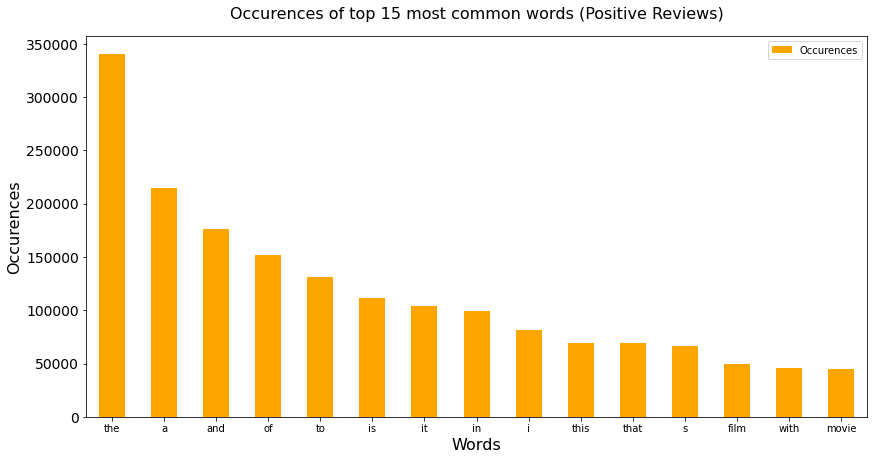

In [30]:
print("\nWord cloud and bar chart of positive reviews (with stop words):")
df_positive = df_processed.loc[df_processed['is_positive'] == 1]
word_frequencies_positive = Counter(" ".join(df_positive["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_positive))
generate_bar_chart(word_frequencies_positive, number_of_words_to_show, "Positive Reviews")


Word cloud and bar chart of negative reviews (with stop words):


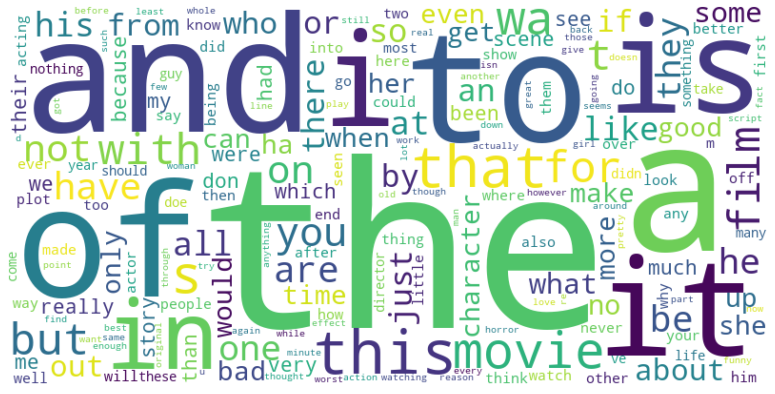

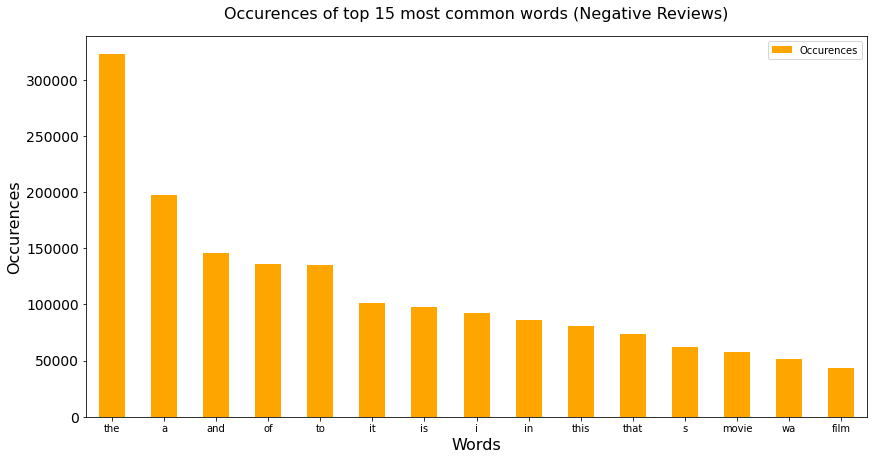

In [46]:
print("\nWord cloud and bar chart of negative reviews (with stop words):")
df_negative = df_processed.loc[df_processed['is_positive'] == 0]
word_frequencies_negative = Counter(" ".join(df_negative["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_negative))
generate_bar_chart(word_frequencies_negative, number_of_words_to_show, "Negative Reviews")


Word cloud and bar chart of both positive and negative reviews (with stop words):


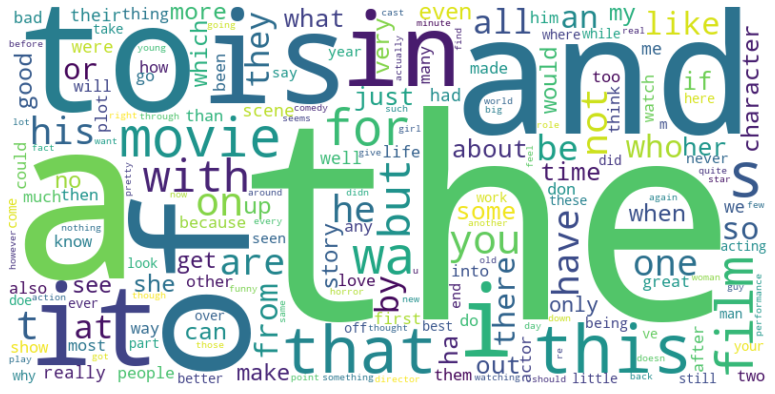

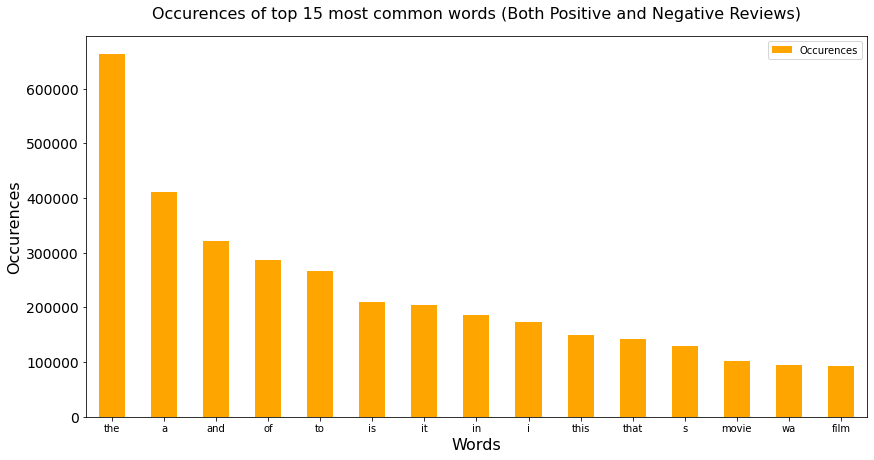

In [47]:
print("\nWord cloud and bar chart of both positive and negative reviews (with stop words):")
df_for_training = df_processed[["cleaned_text", "is_positive"]]
word_frequencies_both_classes = Counter(" ".join(df_for_training["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_both_classes))
generate_bar_chart(word_frequencies_both_classes, number_of_words_to_show, "Both Positive and Negative Reviews")

# Text pre-processing and visualisation (Without stop words)

In [31]:
remove_stop_words = True
df_processed = text_preprocessing(reviews_df_cleaned, "review", remove_stop_words)

number_of_words_to_show = 15

C:\Users\dengc\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: The default value of regex will change from True to False in a future version.


In [51]:
df_processed

,review,sentiment,is_positive,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer ha mentioned watching oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wa wonderful way spend time hot summer...
3,Basically there's a family where a little boy ...,negative,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love time money visually stunnin...
...,...,...,...,...
49577,I thought this movie did a down right good job...,positive,1,thought movie right good job creative original...
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,bad plot bad dialogue bad acting idiotic direc...
49579,I am a Catholic taught in parochial elementary...,negative,0,catholic taught parochial elementary school nu...
49580,I'm going to have to disagree with the previou...,negative,0,going disagree previous comment side maltin on...



Word cloud and bar chart of positive reviews (without stop words):


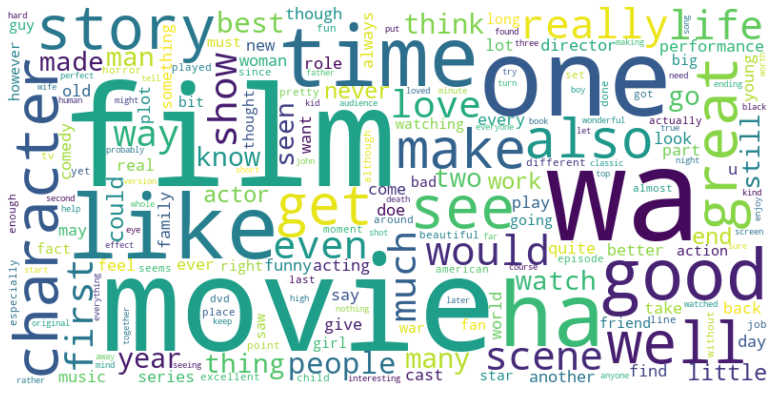

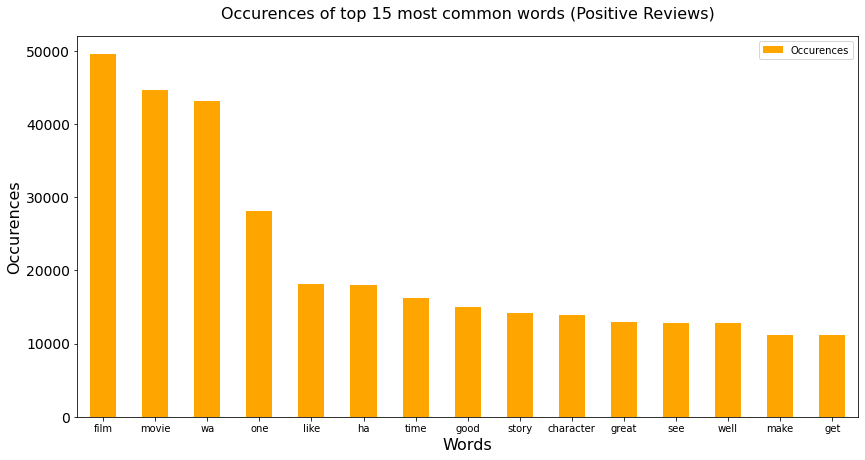

In [52]:
print("\nWord cloud and bar chart of positive reviews (without stop words):")
df_positive = df_processed.loc[df_processed['is_positive'] == 1]
word_frequencies_positive = Counter(" ".join(df_positive["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_positive))
generate_bar_chart(word_frequencies_positive, number_of_words_to_show, "Positive Reviews")


Word cloud and bar chart of negative reviews (without stop words):


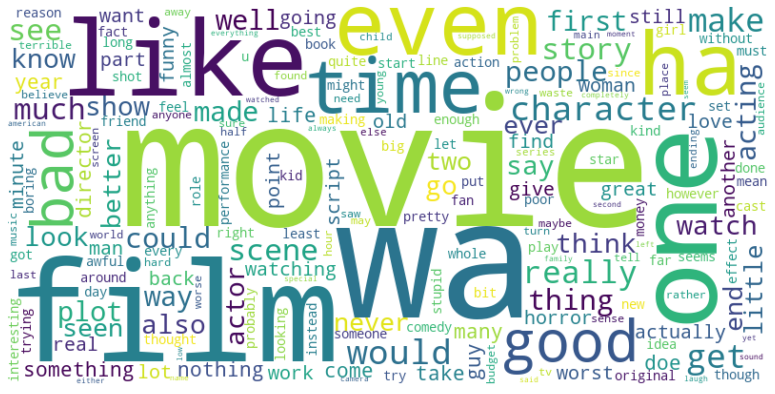

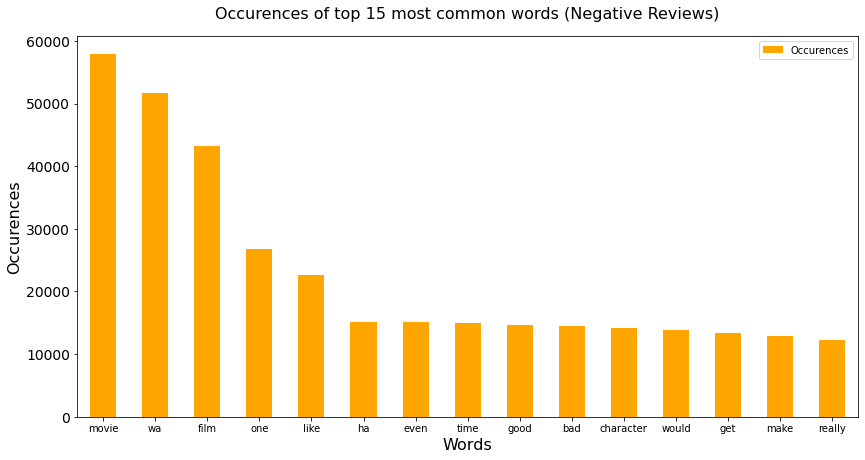

In [53]:
print("\nWord cloud and bar chart of negative reviews (without stop words):")
df_negative = df_processed.loc[df_processed['is_positive'] == 0]
word_frequencies_negative = Counter(" ".join(df_negative["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_negative))
generate_bar_chart(word_frequencies_negative, number_of_words_to_show, "Negative Reviews")


Word cloud and bar chart of both positive and negative reviews (without stop words):


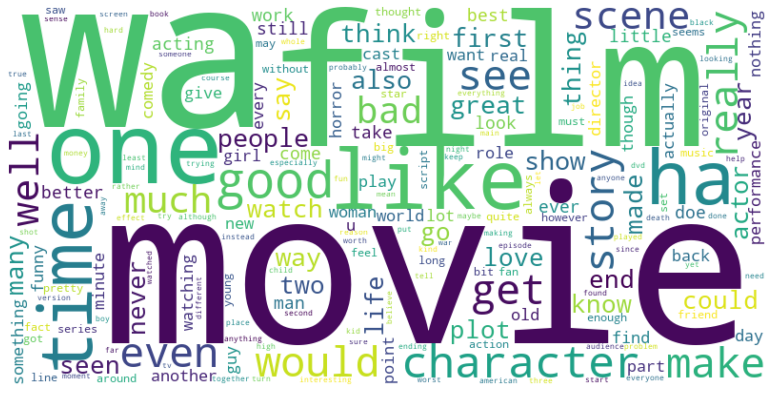

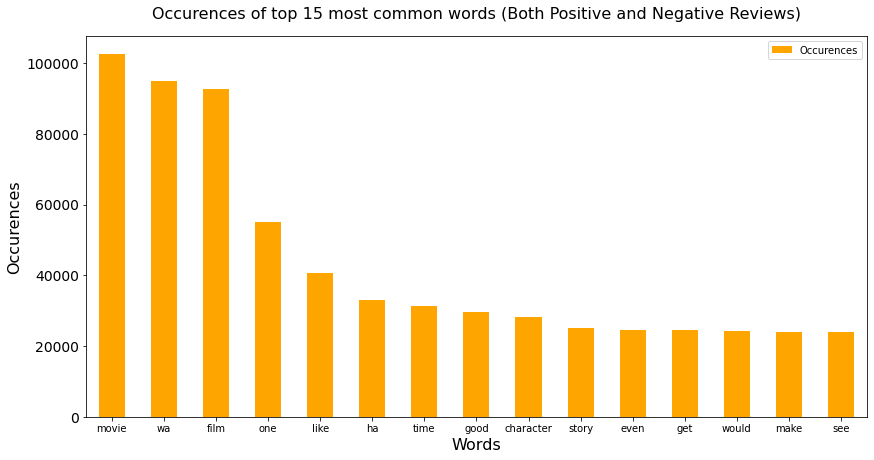

In [54]:
print("\nWord cloud and bar chart of both positive and negative reviews (without stop words):")
df_for_training = df_processed[["cleaned_text", "is_positive"]]
word_frequencies_both_classes = Counter(" ".join(df_for_training["cleaned_text"]).split()) #get word frequencies for each vocab
generate_word_cloud(dict(word_frequencies_both_classes))
generate_bar_chart(word_frequencies_both_classes, number_of_words_to_show, "Both Positive and Negative Reviews")

# Prepare data for training

In [55]:
print("\nSummary of training data:")
distribution_of_data(reviews_df_cleaned, "is_positive", "Negative Reviews", "Positive Reviews")

labels = np.array(df_for_training["is_positive"])
X_train, X_test, y_train, y_test = train_test_split(df_for_training["cleaned_text"], labels, test_size = 0.2, random_state = 0)
list_of_train_sentences = X_train.tolist()
list_of_test_sentences = X_test.tolist()


Summary of training data:
Negative Reviews: 24698
Positive Reviews: 24884
Total data: 49582


In [56]:
unique_vocab = word_frequencies_both_classes.keys()
print("Number of unique vocabulary in training data:", len(unique_vocab))

Number of unique vocabulary in training data: 91694


In [57]:
number_of_splits_one_hot = 5
number_of_splits_BoW = 5
number_of_splits_TF_IDF = 5

# Training the model and evaluating the performance (Logistic Regression)

In [58]:
# Using One-Hot Encoding

clf1_one_hot = LogisticRegression(max_iter = 10000, random_state = 2022)
vectorizer_list1_one_hot, accuracy_list1_one_hot, f1_score_list1_one_hot, clf1_fitted_list_one_hot, time_taken_list1_one_hot = stratified_k_fold_cross_validation_one_hot(clf1_one_hot, list_of_train_sentences, y_train, unique_vocab, number_of_splits_one_hot, show_data_summary = False, show_graphs = False)
model_performance(accuracy_list1_one_hot, f1_score_list1_one_hot, "One-Hot Encoding", "Logistic Regression")

One-Hot Encoding completed
Fold 1 / 5 completed
Time elapsed for training of current fold: 12.370659351348877 seconds

One-Hot Encoding completed
Fold 2 / 5 completed
Time elapsed for training of current fold: 11.672662734985352 seconds

One-Hot Encoding completed
Fold 3 / 5 completed
Time elapsed for training of current fold: 11.393699645996094 seconds

One-Hot Encoding completed
Fold 4 / 5 completed
Time elapsed for training of current fold: 10.944939136505127 seconds

One-Hot Encoding completed
Fold 5 / 5 completed
Time elapsed for training of current fold: 11.908445596694946 seconds

Average accuracy of Logistic Regression Model using One-Hot Encoding: 0.8802974914912391
Average F1-score of Logistic Regression Model (class 1 as positive) using One-Hot Encoding: 0.8812915707473241



In [59]:
# Using Bag-of-Words

clf1_BoW = LogisticRegression(max_iter = 10000, random_state = 2022)
vectorizer_list1_BoW, accuracy_list1_BoW, f1_score_list1_BoW, clf1_fitted_list_BoW, time_taken_list1_BoW = stratified_k_fold_cross_validation_BoW(clf1_BoW, list_of_train_sentences, y_train, unique_vocab, number_of_splits_BoW, show_data_summary = False, show_graphs = False)
model_performance(accuracy_list1_BoW, f1_score_list1_BoW, "BoW", "Logistic Regression")

Bag-of-Words completed
Fold 1 / 5 completed
Time elapsed for training of current fold: 19.208367824554443 seconds

Bag-of-Words completed
Fold 2 / 5 completed
Time elapsed for training of current fold: 18.19054388999939 seconds

Bag-of-Words completed
Fold 3 / 5 completed
Time elapsed for training of current fold: 19.94612956047058 seconds

Bag-of-Words completed
Fold 4 / 5 completed
Time elapsed for training of current fold: 19.088297605514526 seconds

Bag-of-Words completed
Fold 5 / 5 completed
Time elapsed for training of current fold: 19.07735538482666 seconds

Average accuracy of Logistic Regression Model using BoW: 0.8808269255010714
Average F1-score of Logistic Regression Model (class 1 as positive) using BoW: 0.881875640198294



In [60]:
# Using TF-IDF (Term Frequency-Inverse Document Frequency)

clf1_TF_IDF = LogisticRegression(max_iter = 10000, random_state = 2022)
vectorizer_list1_TF_IDF, accuracy_list1_TF_IDF, f1_score_list1_TF_IDF, clf1_fitted_list_TF_IDF, time_taken_list1_TF_IDF = stratified_k_fold_cross_validation_TF_IDF(clf1_TF_IDF, list_of_train_sentences, y_train, unique_vocab, number_of_splits_TF_IDF, show_data_summary = False, show_graphs = False)
model_performance(accuracy_list1_TF_IDF, f1_score_list1_TF_IDF, "TF-IDF", "Logistic Regression")

TF-IDF completed
Fold 1 / 5 completed
Time elapsed for training of current fold: 7.482727766036987 seconds

TF-IDF completed
Fold 2 / 5 completed
Time elapsed for training of current fold: 7.14461874961853 seconds

TF-IDF completed
Fold 3 / 5 completed
Time elapsed for training of current fold: 7.443639039993286 seconds

TF-IDF completed
Fold 4 / 5 completed
Time elapsed for training of current fold: 7.902719736099243 seconds

TF-IDF completed
Fold 5 / 5 completed
Time elapsed for training of current fold: 6.292439699172974 seconds

Average accuracy of Logistic Regression Model using TF-IDF: 0.892550107147359
Average F1-score of Logistic Regression Model (class 1 as positive) using TF-IDF: 0.8943188712945517



# Training the model and evaluating the performance (Convolutional Neural Network)

In [61]:
# Using One-Hot Encoding

clf2_one_hot = CNN(X_train, y_train, X_test, y_test) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          32000     
                                                                 
 conv1d (Conv1D)             (None, 1000, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 500, 32)           0         
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 250)               4000250   
                                                        

# Training Logistic Regression Model on TF-IDF vectorizations for full dataset

In [71]:
start = time.time()
clf_TF_IDF_lr = LogisticRegression(max_iter = 10000, random_state = 2022)
TF_IDF_train_data, TF_IDF_vectorizer = TF_IDF_vectorization_full(list_of_train_sentences, unique_vocab)
clf_TF_IDF_lr.fit(TF_IDF_train_data, y_train)
end = time.time()
print("Time elapsed for training Logistic Regression model with TF-IDF vectorization:", (end - start), "seconds")

TF-IDF vectorization completed
Time elapsed for training Logistic Regression model with TF-IDF vectorization: 17.10092806816101 seconds


In [72]:
y_pred_train = clf_TF_IDF_lr.predict(TF_IDF_train_data)

print("Accuracy (Train data):", accuracy_score(y_pred_train, y_train))
print("F1 Score (Train data):", f1_score(y_pred_train, y_train))

Accuracy (Train data): 0.9323837136014118
F1 Score (Train data): 0.9331071980845015


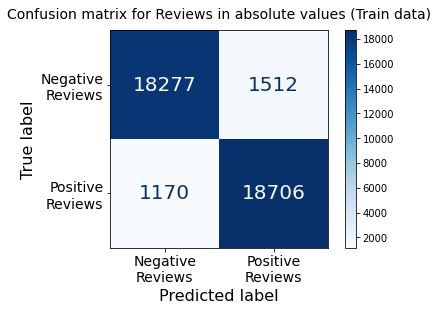

In [73]:
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
cmd_obj = ConfusionMatrixDisplay(confusion_matrix_train, display_labels=["Negative\nReviews", "Positive\nReviews"])
cmd_obj.plot(values_format = "d", cmap = plt.cm.Blues)
for labels in cmd_obj.text_.ravel():
    labels.set_fontsize(20)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Confusion matrix for Reviews in absolute values (Train data)", fontsize = 14, y = 1.03)
plt.xlabel("Predicted label", fontsize = 16)
plt.ylabel("True label", fontsize = 16)
plt.show();

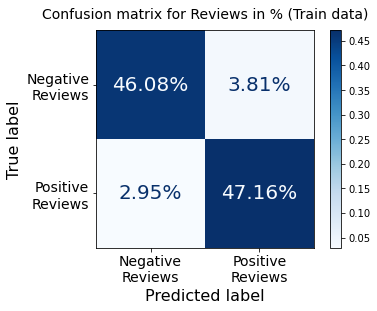

In [74]:
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
cmd_obj = ConfusionMatrixDisplay(confusion_matrix_train/np.sum(confusion_matrix_train), display_labels=["Negative\nReviews", "Positive\nReviews"])
cmd_obj.plot(values_format = ".2%", cmap = plt.cm.Blues)
for labels in cmd_obj.text_.ravel():
    labels.set_fontsize(20)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Confusion matrix for Reviews in % (Train data)", fontsize = 14, y = 1.03)
plt.xlabel("Predicted label", fontsize = 16)
plt.ylabel("True label", fontsize = 16)
plt.show();

In [75]:
TF_IDF_test_data = TF_IDF_vectorizer.transform(list_of_test_sentences)

In [76]:
y_pred_test = clf_TF_IDF_lr.predict(TF_IDF_test_data)

print("Accuracy (Test data):", accuracy_score(y_pred_test, y_test))
print("F1 Score (Test data):", f1_score(y_pred_test, y_test))

Accuracy (Test data): 0.8891801956236766
F1 Score (Test data): 0.8915638875185001


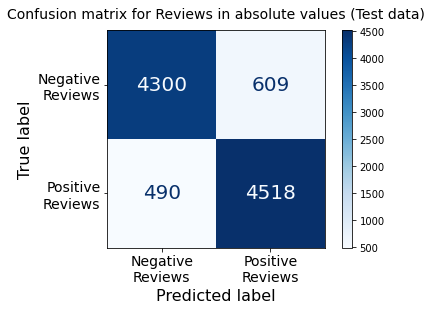

In [77]:
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
cmd_obj = ConfusionMatrixDisplay(confusion_matrix_test, display_labels=["Negative\nReviews", "Positive\nReviews"])
cmd_obj.plot(values_format = "d", cmap = plt.cm.Blues)
for labels in cmd_obj.text_.ravel():
    labels.set_fontsize(20)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Confusion matrix for Reviews in absolute values (Test data)", fontsize = 14, y = 1.03)
plt.xlabel("Predicted label", fontsize = 16)
plt.ylabel("True label", fontsize = 16)
plt.show();

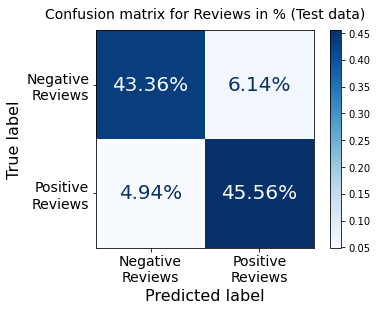

In [78]:
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
cmd_obj = ConfusionMatrixDisplay(confusion_matrix_test/np.sum(confusion_matrix_test), display_labels=["Negative\nReviews", "Positive\nReviews"])
cmd_obj.plot(values_format = ".2%", cmap = plt.cm.Blues)
for labels in cmd_obj.text_.ravel():
    labels.set_fontsize(20)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Confusion matrix for Reviews in % (Test data)", fontsize = 14, y = 1.03)
plt.xlabel("Predicted label", fontsize = 16)
plt.ylabel("True label", fontsize = 16)
plt.show();

# Interpretability of model using Lime

Statement with index 2
Actual label: 1 (Positive Review)
Predicted label: 1 (Positive Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.9905
Review given: one time great science fiction work visionary thought provoking blade runner even gilliam brazil willis give best performance outdone pitt incredibly frenetic turn unlike anything done since even stowe league though story layered offer quite lot think climactic scene beautifully magnificent last line fit perfectly scene mental hospital creepy yet funny way lot dark humour display fantastic production design suitably bizarre cinematography top ten


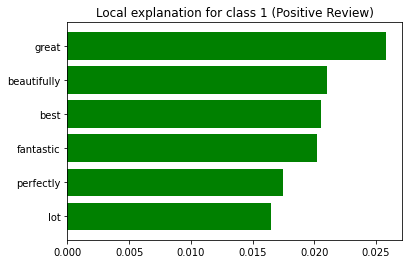



Statement with index 3
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.145
Review given: mickey rourke wa famous movie star play martin fallon ira terrorist accidentally blow school bus full child disgusted action decides leave ira go run london mild spoiler movie opening rather disturbing life little child ended fireball thing like happened throughout northern ireland give prayer dying stark realism however soon fallon decides going give violence terrorist never blown innocent passerby realism disappears clich ridiculous plot twist take place martin employed london underworld hit men commit hit wear ira uniform never knew provo wore uniform cemetery broad daylight ira man use bomb placed car spotted priest recognises wa sa hand think lying half way running time still several clich come sound silly expect novel jack higgins everything clich contrived stereotypical bit pla

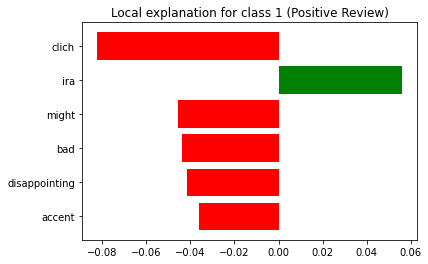

In [79]:
indexes = [2,3]
labels = np.array(df_for_training["is_positive"])

for index in indexes:
    print("Statement with index " + str(index))
    predicted_label_TF_IDF = predict_statement(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[index])
    print("Actual label: " + str(y_test[index]) + " (" + label_to_class(labels[index], "Negative Review", "Positive Review") + ")")
    print("Predicted label: " + str(predicted_label_TF_IDF[0]) + " (" + label_to_class(labels[index], "Negative Review", "Positive Review") + ")")
    print("")

    if predicted_label_TF_IDF == [-1]:
        print("Error in classification, unable to check interpretability of model")
    else:
        explain_with_lime(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[index])
    print("\n")

# Using Cosine Similarity to find sentences similar to a reference sentence

In [82]:
random.seed(5010)
compareindex = random.randint(0,len(list_of_test_sentences)-1)
top5sentences = find_top_5(list_of_test_sentences,compareindex)

Ran first 1000 indexes
Ran first 2000 indexes
Ran first 3000 indexes
Ran first 4000 indexes
Ran first 5000 indexes
Ran first 6000 indexes
Ran first 7000 indexes
Ran first 8000 indexes
Ran first 9000 indexes


Reference sentence
Statement with index 5049
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.14
Review given: concorde airport start washington man named carl parker macon mccalman contact high profile tv news reporter maggie whelan susan blakely order hand secret document prove bos kevin harriosn robert wagner owner president harrison industry develop weapon military ha illegally selling said weapon foreign country however maggie see carl assassinated barely escape life maggie catch concorde moscow via paris next morning intends blow whistle harrison also happens boyfriend would ruin determined save reprogrammes hi tech buzzard homing missile intercept destroy concorde test run killing board destroying documented evidence renamed airport concorde cinema initial home video release wa released well rather last entry airport franchise wa directed david lowell rich notoriously

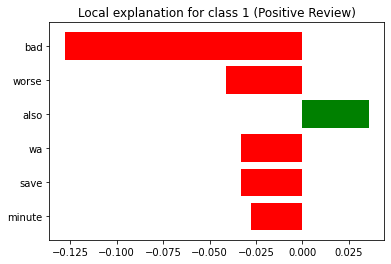



Statement with index 677
Cosine similarity with index 5049: 0.475
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.0877
Review given: warning spoiler lord know seen bad movie time one make angry insult people looking bad movie story involves stewardess discovers boyfriend badly acted otherwise great robert wagner murder thief overall puke face concorde take sends guided missile destroy concorde concorde traveling speed light hero played utter stupidity george kennedy open window cockpit stick hand window fire missile rocket scientist seems hand would least get wind burn towards final climax concorde headed certain disaster everyone die passenger turn fiance proposes marriage priest happens sitting next row proceeds marry plane crashing making wow guy wrote script must sniffing glue week


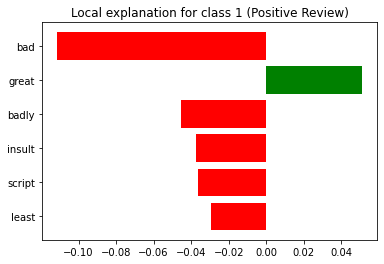



Statement with index 8900
Cosine similarity with index 5049: 0.382
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.3858
Review given: airport basically slopped together mess universal studio try work new twist concorde supersonic airliner disaster sky formula bogged unintentional humor best george kennedy stick hand concorde window supersonic speed fire flare gun heat seeking missile following aircraft flight path simple fact dumb passenger keep boarding plane continue flight despite problem air many star one including robert wagner sylvia kristel alain delon martha raye nervous passenger really related airport film


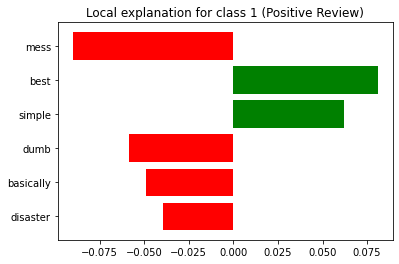



Statement with index 2464
Cosine similarity with index 5049: 0.371
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.068
Review given: bad movie movie horrible tiny rarified body movie horribly bad even seeing sheer awfulness make impossible forget even decade later exactly movie hard believe original film series wa actually quite good let see george kennedy cigar chomping tough guy mechanic original ha somehow promoted airline captain concorde come missile attack ask resort stunt like shooting flare gun cockpit window despite presumably flying mach sort wild high g evasive maneuver would ripped wing real airliner never mind effect passenger absolute worst part film least dedicated airplane buff like atrocity starred one coolest sexiest technologically remarkable plane ever fly concorde plain concorde pilot refer deserved far better abomination equivalent taking high class 

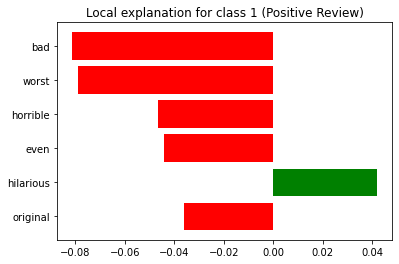



Statement with index 3448
Cosine similarity with index 5049: 0.312
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.2088
Review given: concorde airport last high drama high camp airport series first glance tv guide dvd cover would simply think film view thrilling previous airport think treated hour minute worth unintentional laugh courtesy worst script ever writing wa even penned eric roth brought world forrest gump well one thing sure script oscar worthy razzie worthy executive universal done right thing marketing comedy apart charo film doe impressive cast list certainly watchable say least


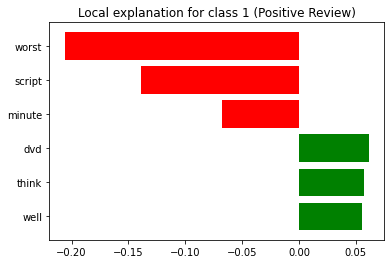



Statement with index 1266
Cosine similarity with index 5049: 0.241
Actual label: 0 (Negative Review)
Predicted label: 0 (Negative Review)

Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.1571
Review given: saw movie tnt let tell movie wa downright corny cheezy certain point began laugh sock tell truth classify movie comedy rather action adventure absolutely hilarious scene come delon kennedy making loop loop avoid french missile wagner ordered destroy concorde fearless leader kennedy decides shoot flare window stop heat seeking missile dumb yet funny kicker come though one shot flare gun malfunction kennedy try fix cockpit well want know happens get hold movie dumb part movie include total lack plot yeah let action minute land paris go one hour love scene prostitute flight attendant let switch saboteur ten minute wasted rest movie plane visually breaking apart passenger even see right front eye final rating move star action star comedy


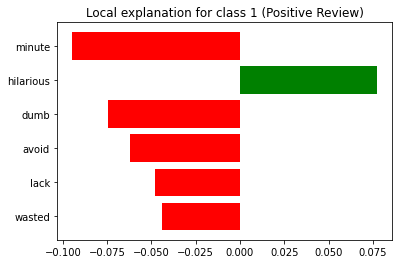

In [83]:
indexes = []
top5sentences.reverse()
for top5 in top5sentences:
    indexes.append(top5[1])
    
labels = np.array(df_for_training["is_positive"])

print("Reference sentence")
print("Statement with index " + str(compareindex))
predicted_label_TF_IDF = predict_statement(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[compareindex])
print("Actual label: " + str(y_test[compareindex]) + " (" + label_to_class(y_test[compareindex], "Negative Review", "Positive Review") + ")")
print("Predicted label: " + str(predicted_label_TF_IDF[0]) + " (" + label_to_class(predicted_label_TF_IDF[0], "Negative Review", "Positive Review") + ")")
print("")

if predicted_label_TF_IDF == [-1]:
    print("Error in classification, unable to check interpretability of model")
else:
    explain_with_lime(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[compareindex])
print("\n")


i=0
for index in indexes:
    print("Statement with index " + str(index))
    print("Cosine similarity with index " + str(compareindex) +": " + str(round(top5sentences[i][0],3)))
    predicted_label_TF_IDF = predict_statement(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[index])
    print("Actual label: " + str(y_test[index]) + " (" + label_to_class(y_test[index], "Negative Review", "Positive Review") + ")")
    print("Predicted label: " + str(predicted_label_TF_IDF[0]) + " (" + label_to_class(predicted_label_TF_IDF[0], "Negative Review", "Positive Review") + ")")
    print("")
    
    if predicted_label_TF_IDF == [-1]:
        print("Error in classification, unable to check interpretability of model")
    else:
        explain_with_lime(TF_IDF_vectorizer, clf_TF_IDF_lr, list_of_test_sentences[index])
    print("\n")
    i+=1

# Trying out our models using our own handcrafted sentences

Predicted label: 0 (Negative Review)
Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.141
Review given: Spiderman is not bad la hor


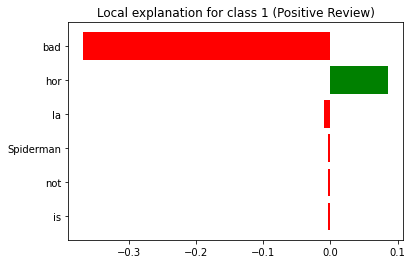

In [84]:
test_sentence_1 = "Spiderman is not bad la hor"

predicted_label_TF_IDF = predict_statement(TF_IDF_vectorizer, clf_TF_IDF_lr, test_sentence_1)
print("Predicted label: " + str(predicted_label_TF_IDF[0]) + " (" + label_to_class(predicted_label_TF_IDF, "Negative Review", "Positive Review") + ")")

if predicted_label_TF_IDF == [-1]:
    print("Error in classification, unable to check interpretability of model")
else:
    explain_with_lime(TF_IDF_vectorizer, clf_TF_IDF_lr, test_sentence_1)

Predicted label: 0 (Negative Review)
Explaination using LIME:
Probability of review being classified as 1 (Positive Review): 0.3118
Review given: Dr Smitha and Dr Sourav please give our group project an A thank you!


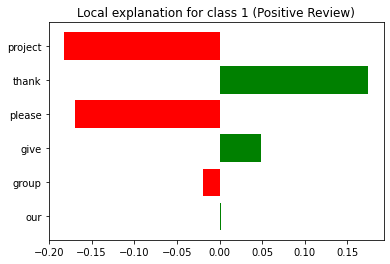

In [85]:
test_sentence_2 = "Dr Smitha and Dr Sourav please give our group project an A thank you!"

predicted_label_TF_IDF = predict_statement(TF_IDF_vectorizer, clf_TF_IDF_lr, test_sentence_2)
print("Predicted label: " + str(predicted_label_TF_IDF[0]) + " (" + label_to_class(predicted_label_TF_IDF, "Negative Review", "Positive Review") + ")")

if predicted_label_TF_IDF == [-1]:
    print("Error in classification, unable to check interpretability of model")
else:
    explain_with_lime(TF_IDF_vectorizer, clf_TF_IDF_lr, test_sentence_2)